# Feature Engineering

In [1]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm

In [2]:
# Load training set
df = pd.read_csv('cleaned_data.csv')

In [3]:
df.keys()

Index(['price_id1', 'bedrooms_id1', 'bathrooms_id1', 'totalArea_id1',
       'price_id2', 'bedrooms_id2', 'bathrooms_id2', 'totalArea_id2',
       'apartment_dummy_1', 'house_dummy_1', 'plot_dummy_1',
       'investment_dummy_1', 'other_dummy_1', 'apartment_dummy_2',
       'house_dummy_2', 'plot_dummy_2', 'investment_dummy_2', 'other_dummy_2',
       'target', 'title_id1', 'title_id2', 'description_id1',
       'description_id2'],
      dtype='object')

Our goal is to accurately predict if two real-estate listings are the same. They should in theory report similar prices, bedrooms, bathrooms, area size, type of property etc. The title and description should be similar as well. 

To capture differences we're going to subtract the differences amongst features from each listing. If they are similar we should see a lot of zeros, and this will also reduce features by half. For the description and title, we're going to use our Word2Vec Model and implement cosine similarity. 

### Numeric Features (differences)

In [4]:
price_difference = np.abs(df['price_id1'] - df['price_id2'])
bedroom_difference = np.abs(df['bedrooms_id1'] - df['bedrooms_id2'])
bathroom_difference = np.abs(df['bathrooms_id1'] - df['bathrooms_id2'])
area_difference = np.abs(df['totalArea_id1'] - df['totalArea_id2'])
apartment_dummy_difference = np.abs(df['apartment_dummy_1'] - df['apartment_dummy_2'])
house_dummy_difference = np.abs(df['house_dummy_1'] - df['house_dummy_2'])
plot_dummy_difference = np.abs(df['plot_dummy_1'] - df['plot_dummy_2'])
investment_dummy_difference = np.abs(df['investment_dummy_1'] - df['investment_dummy_2'])
other_dummy_difference = np.abs(df['other_dummy_1'] - df['other_dummy_2'])

###  Cosine Similarity

In [5]:
# Description columns

# Load Description columns vectorized by Word2Vec Model
d1np = np.load('d1np.npy' , allow_pickle=True)
d2np = np.load('d2np.npy' , allow_pickle=True)

#Calculate cosine similarity
description_cos_similarity = []
for i in range(len(d1np)):
        description_cos_similarity.append(np.dot(d1np[i],d2np[i])/(norm(d1np[i])*norm(d2np[i])))

In [6]:
# Title columns

# Load Title columns vectorized by Word2Vec Model
t1np = np.load('t1np.npy' , allow_pickle=True)
t2np = np.load('t2np.npy' , allow_pickle=True)

# Calculate cosine similarity
title_cos_similarity = []
for i in range(len(t1np)):
        title_cos_similarity.append(np.dot(t1np[i],t2np[i])/(norm(t1np[i])*norm(t2np[i])))

In [7]:
features = pd.DataFrame()

In [8]:
features['price_difference'] = price_difference
features['bedroom_difference'] = bedroom_difference
features['bathroom_difference'] = bathroom_difference
features['area_difference'] = area_difference
features['apartment_dummy_difference'] = apartment_dummy_difference
features['house_dummy_difference'] = house_dummy_difference
features['plot_dummy_difference'] = plot_dummy_difference
features['investment_dummy_difference'] = investment_dummy_difference
features['other_dummy_difference'] = other_dummy_difference

In [9]:
features['description_cos_similarity'] = description_cos_similarity
features['title_cos_similarity'] = title_cos_similarity

In [10]:
features['target']  = df['target']

In [11]:
features.shape

(502689, 12)

In [12]:
features.dtypes

price_difference               float64
bedroom_difference             float64
bathroom_difference            float64
area_difference                float64
apartment_dummy_difference     float64
house_dummy_difference         float64
plot_dummy_difference          float64
investment_dummy_difference    float64
other_dummy_difference         float64
description_cos_similarity     float64
title_cos_similarity           float64
target                           int64
dtype: object

In [13]:
X = features.iloc[:,:-1].values
y = features['target'].values

## Modelling

Will implement three different models with different parameters and see which one fits the best. Will utilize AdaBoosting (HistGradientBoosting), Logistic Regression & XGBoost. 

Metric used will be % of correct cases predicted 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix

##### XGBoost

In [15]:
params = {"objective":"binary:hinge",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

In [16]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [17]:
xg_class = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)

In [18]:
y_pred = xg_class.predict(data_dmatrix)

In [19]:
c = confusion_matrix(y,y_pred)

In [20]:
correct_cases = ((c[0][0] + c[1][1])/ (c[0][0] + c[1][1] + c[1][0] + c[0][1]))*100
print("% of correct cases predicted is " + str(correct_cases))

% of correct cases predicted is 81.94509925620017


##### Logistic Regression

In [21]:
logit = LogisticRegression()
log_model = logit.fit(X,y)
y_pred = log_model.predict(X)
c = confusion_matrix(y,y_pred)
c

array([[393647,      0],
       [109042,      0]])

In [22]:
correct_cases = ((c[0][0] + c[1][1])/ (c[0][0] + c[1][1] + c[1][0] + c[0][1]))*100
print("% of correct cases predicted is " + str(correct_cases))

% of correct cases predicted is 78.3082581874678


Nearly mis-classifies everything. Does well on prediciting the true negatives but awful with the ones that are the same. In fact thinks that all every single listing is not the same. This is useless because here we are effectively just taking the average from our y-variable

#### Ada Boosting

In [23]:
clf = AdaBoostClassifier().fit(X,y)

In [24]:
y_pred = clf.predict(X)

In [25]:
c = confusion_matrix(y,y_pred)
correct_cases = ((c[0][0] + c[1][1])/ (c[0][0] + c[1][1] + c[1][0] + c[0][1]))*100
print("% of correct cases predicted is " + str(correct_cases))

% of correct cases predicted is 85.57020344586812


In [27]:
feature_imp = pd.Series(clf.feature_importances_,index=features.iloc[:,:-1].columns).sort_values(ascending=False)

No handles with labels found to put in legend.


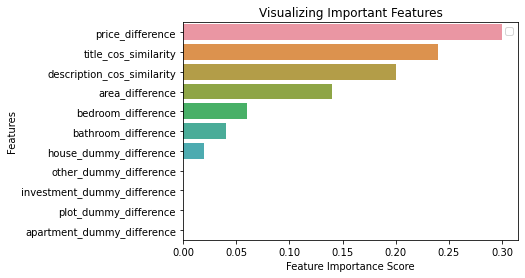

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#### HistGradientBoosting (Adaptation of Gradient Boosting)

In [29]:
 # explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingClassifier

In [30]:
clf = HistGradientBoostingClassifier(loss='binary_crossentropy'  , max_iter= 2000).fit(X, y)

In [31]:
y_pred = clf.predict(X)

In [32]:
c = confusion_matrix(y,y_pred)
correct_cases = ((c[0][0] + c[1][1])/ (c[0][0] + c[1][1] + c[1][0] + c[0][1]))*100
print("% of correct cases predicted is " + str(correct_cases))

% of correct cases predicted is 88.96176363517006


Testing over four models, HistGradientBoosting performs the best

### Save Model will be used on test set 

In [33]:
import pickle
filename = 'hist_gradient_boosting_finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))